In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.sims.voxel import multi_tensor, multi_tensor_odf, single_tensor
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
np.random.seed = 2
n_pts = 64
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

hsph_updated, potential = disperse_charges(hsph_initial, 5000)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])

bvecs = np.vstack((vertices, vertices))
bvals = np.hstack((1000 * values, 2500 * values))

bvecs = np.insert(bvecs, (0, bvecs.shape[0]), np.array([0, 0, 0]), axis=0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)

# Fixed diffusivity parameters 
d_parallel = 0.0015
d_perp = 0.0003
eigenvals = [d_parallel, d_perp, d_perp]

# Generate n pairs of angles 
n = 360
angle_pairs = []
H = np.zeros((n, len(bvals)))
H_noisy = np.zeros((n, len(bvals)))
for i in range(n):
    angle_pair = (np.random.uniform(0,180), np.random.uniform(0,360))
    angle_pairs.append(angle_pair)
    H[i] = multi_tensor(gtab, mevals = [eigenvals], S0=100, angles = [angle_pair], fractions = [100], snr = None)[0]
    H_noisy[i] = multi_tensor(gtab, mevals = [eigenvals], S0=100, angles = [angle_pair], fractions = [100], snr = 20)[0]


N = 1000
# Generating Nf
Nf = np.random.randint(3, size = N) + 1

# Creating S and our ground-truth

S = np.zeros((N, len(bvals)))
S_noisy = np.zeros((N, len(bvals)))
F = np.zeros((N, n))

for i, k in enumerate(Nf):
    indices = np.random.randint(n, size=k)
    random_fracs = np.random.uniform(size=k)
    random_fracs /= np.sum(random_fracs)
    for j in range(k):
        S[i] += random_fracs[j] * H[indices[j]]
        S_noisy[i] += random_fracs[j] * H_noisy[indices[j]]
        F[i][indices[j]] = random_fracs[j]

In [20]:
print(f"Size of bval:{bvals.shape}")
print(f"Size of H:{H.shape}")
print(f"Size of S:{S.shape}")

Size of bval:(130,)
Size of H:(360, 130)
Size of S:(1000, 130)


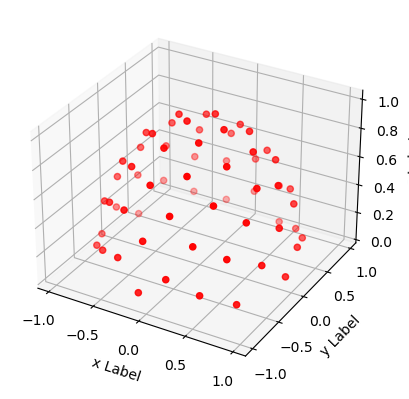

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the points
ax.scatter(vertices[:,0], vertices[:,1], vertices[:,2], c='r', marker='o')

# Set labels for each axis
ax.set_xlabel('x Label')
ax.set_ylabel('y Label')
ax.set_zlabel('z Label')

# Show the plot
plt.show()

In [3]:
class SparsemaxLayer(nn.Module):
    def __init__(self):
        super(SparsemaxLayer, self).__init__()

    def forward(self, x):
        return torch.nn.functional.log_softmax(x, dim=-1)

# Define the custom loss
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, S, F, H):
        # Compute the custom loss: (S - FH)^2
        loss = torch.sum((S - torch.matmul(F, H))**2)
        return loss

# Define the model with ReLU activation
class RatioEstimationModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(RatioEstimationModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sparsemax = SparsemaxLayer()
        self.relu = nn.ReLU()  # Add ReLU activation

    def forward(self, x):
        x = self.fc(x)
        x = self.sparsemax(x)
        x = self.relu(x)  # Apply ReLU activation to ensure non-negative values
        return x

# Sample input sizes
input_size = 130  # Adjust based on your input size
output_size = 360   # Adjust based on your desired output size

# Instantiate the model and custom loss
model = RatioEstimationModel(input_size, output_size)
model.to(torch.float64)
custom_loss = CustomLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop (replace this with your actual training data)
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(torch.tensor(S_noisy))
    
    # Compute the custom loss
    loss = custom_loss(torch.tensor(S_noisy), outputs, torch.tensor(H))
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    # Print the loss at every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, you can use the model to make predictions on new data
# Replace `new_input` with your actual input data
new_input = torch.randn(1, input_size)
predicted_output = model(new_input)
print("Predicted Output:")
print(predicted_output)

Epoch [10/100], Loss: 263419180.3890
Epoch [20/100], Loss: 263419180.3890
Epoch [30/100], Loss: 263419180.3890
Epoch [40/100], Loss: 263419180.3890
Epoch [50/100], Loss: 263419180.3890
Epoch [60/100], Loss: 263419180.3890
Epoch [70/100], Loss: 263419180.3890
Epoch [80/100], Loss: 263419180.3890
Epoch [90/100], Loss: 263419180.3890
Epoch [100/100], Loss: 263419180.3890


RuntimeError: mat1 and mat2 must have the same dtype

In [25]:
a = torch.tensor(S)
a.dtype

torch.float64

In [40]:
loss.item()

263431116.0269025